# Libraries

In [1]:
import pandas as pd
import numpy as np
import random
import time
import sys
import os
import gc


from tqdm.notebook import tqdm
from itertools import cycle

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score

from sklearn.linear_model import RidgeCV
import lightgbm as lgb
import xgboost as xgb
import catboost as ctb

import shap

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Parameters

In [2]:
N_SPLITS = 10
N_REPEATS = 5
N_ESTIMATORS = 30000  # LightGBM, XGBoost, CatBoost
EARLY_STOPPING_ROUNDS = 1000
VERBOSE = False
SEED = 42

In [3]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(SEED)

# Data Loading

In [4]:
%%time
train = pd.read_csv("../input/netflix-appetency/train.csv")
test = pd.read_csv("../input/netflix-appetency/test.csv")
submission = pd.read_csv("../input/netflix-appetency/sample_submission.csv")

train.shape, test.shape, submission.shape

CPU times: user 4.6 s, sys: 495 ms, total: 5.09 s
Wall time: 6.46 s


((70000, 509), (30000, 508), (30000, 2))

# Preprocessing datasets

###  - Drop features
- Drop null value features
- Drop single categorical features
- Drop single value features

In [5]:
# all null value features
drop_columns = [
    'feature_193', 'feature_196', 'feature_197', 'feature_198',
    'feature_83',
]
# single catgorical features
drop_columns.extend([
    'feature_190', 'feature_55', 'feature_187', 'feature_188',
    'feature_249', 'feature_248',
])
# single value features
drop_columns.extend([
       'feature_461', 'feature_474', 'feature_472', 'feature_409',
       'feature_469', 'feature_467', 'feature_411', 'feature_465',
       'feature_312', 'feature_463', 'feature_313', 'feature_375',
       'feature_427', 'feature_412', 'feature_413', 'feature_455',
       'feature_453', 'feature_419', 'feature_451', 'feature_100',
       'feature_449', 'feature_421', 'feature_445', 'feature_433',
       'feature_432', 'feature_459', 'feature_476', 'feature_405',
       'feature_425', 'feature_498', 'feature_227', 'feature_228',
       'feature_149', 'feature_495', 'feature_385', 'feature_493',
       'feature_478', 'feature_491', 'feature_389', 'feature_489',
       'feature_252', 'feature_487', 'feature_502', 'feature_505',
       'feature_484', 'feature_395', 'feature_482', 'feature_377',
       'feature_358', 'feature_480', 'feature_397', 'feature_357',
       'feature_500'
])

train = train.drop(columns=drop_columns)
test = test.drop(columns=drop_columns)

train.shape, test.shape

((70000, 445), (30000, 444))

### - Convert datetime columns

In [6]:
date_columns = [
    'feature_191', 'feature_192', 'feature_194', 'feature_195',
    'feature_199', 'feature_200', 'feature_201', 'feature_202',
    'feature_203', 'feature_204'
]

for date_column in date_columns:
    train[date_column] = pd.to_datetime(train[date_column]).dt.year.fillna(-1).astype(int)
    test[date_column] = pd.to_datetime(test[date_column]).dt.year.fillna(-1).astype(int)

### - Categorical Columns

In [7]:
cat_features = [col for col in train.select_dtypes('object').columns]
train[cat_features].head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_16,feature_17,feature_18,feature_19,feature_20,...,feature_288,feature_289,feature_290,feature_291,feature_292,feature_293,feature_336,feature_337,feature_338,feature_371
0,C0,C0,C1,C5,C11,C0,C60,C17795,C413,C3620,...,C130,C46,C22,C10,C7,C6,C0,C0,C0,C0
1,C0,C0,C3,C5,C1,C2,C50,C14050,C413,C2819,...,C105,C36,C18,C6,C3,C2,C0,C0,C0,C0
2,C0,C0,C3,C5,C2,C1,C76,C23471,C413,C4794,...,C105,C36,C18,C6,C3,C2,C0,C0,C0,C0
3,C0,C0,C1,C5,C1,C0,C58,C16929,C413,C3344,...,C83,C28,C13,C2,C1,C0,C0,C0,C0,C0
4,C0,C0,C3,C3,C11,C2,C48,C13941,C413,C2753,...,C93,C24,C11,C2,C1,C0,C0,C0,C0,C1


### - Numarical Columns

In [8]:
target_column = 'target'
drop_columns = ['id', target_column]

num_features = [col for col in train.select_dtypes(['int', 'float']).columns if col not in drop_columns]
train[num_features].head()

,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,...,feature_490,feature_492,feature_494,feature_496,feature_497,feature_499,feature_501,feature_503,feature_504,feature_506
0,37.56,54.756667,54.756667,35.83,39.136667,39.136667,2.5,3.026667,3.026667,0.0,...,0,0,0,0,0,0,0,0,0,0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,0,0,0,0,0,0,0,0,0,0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,0,0,0,0,0,0,0,0,0,0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,0,0,0,0,0,0,0,0,0,0
4,37.48,37.480000,37.161333,35.75,35.750000,35.750000,2.5,2.500000,2.500000,0.0,...,0,0,0,0,0,0,0,0,0,0


### - Label encoding

In [9]:
def label_encoding(train_df, test_df, columns):
    for col in columns:
        le = LabelEncoder()
        values = train_df[col].append(test_df[col])
        le.fit(values)
        train_df[col] = le.transform(train_df[col])
        test_df[col] = le.transform(test_df[col])
    return train_df, test_df

train, test = label_encoding(train, test, cat_features)
train[cat_features].head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_16,feature_17,feature_18,feature_19,feature_20,...,feature_288,feature_289,feature_290,feature_291,feature_292,feature_293,feature_336,feature_337,feature_338,feature_371
0,0,0,1,5,3,0,61,5737,263,2808,...,28,34,14,2,6,5,0,0,0,0
1,0,0,3,5,1,2,50,3082,263,1951,...,7,26,9,7,3,2,0,0,0,0
2,0,0,3,5,4,1,78,9673,263,4066,...,7,26,9,7,3,2,0,0,0,0
3,0,0,1,5,1,0,58,5079,263,2516,...,101,19,5,3,1,0,0,0,0,0
4,0,0,3,3,3,2,47,3016,263,1881,...,112,16,3,3,1,0,0,0,0,1


### - Fill missing values

In [10]:
train[num_features] = train[num_features].fillna(train[num_features].mean())
test[num_features] = test[num_features].fillna(test[num_features].mean())

### - Feature engineering

In [11]:
grpby_columns = train[cat_features].columns[train[cat_features].nunique()<100]
target_columns = ['feature_81', 'feature_307']
func_l = ['mean']
fe_features = []

for grpby_col in grpby_columns:
    for target_col in target_columns:
        for func in func_l:
            tmp = train.groupby(grpby_col)[target_col].agg(func).rename(f'{func}_{target_col}_grpby_{grpby_col}')
            train = train.merge(tmp, on=grpby_col, how='left')
            tmp = test.groupby(grpby_col)[target_col].agg(func).rename(f'{func}_{target_col}_grpby_{grpby_col}')
            test = test.merge(tmp, on=grpby_col, how='left')
            fe_features += [f'{func}_{target_col}_grpby_{grpby_col}']

num_features += fe_features

In [12]:
train.shape, test.shape

((70000, 569), (30000, 568))

### - MinMaxScaling

In [13]:
scaler = MinMaxScaler()

train[num_features] = scaler.fit_transform(train[num_features])
test[num_features] = scaler.transform(test[num_features])

# Check and preview NaN

In [14]:
display(train[train.isna().any(axis=1)])
display(test[train.isna().any(axis=1)])

,id,target,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,mean_feature_81_grpby_feature_293,mean_feature_307_grpby_feature_293,mean_feature_81_grpby_feature_336,mean_feature_307_grpby_feature_336,mean_feature_81_grpby_feature_337,mean_feature_307_grpby_feature_337,mean_feature_81_grpby_feature_338,mean_feature_307_grpby_feature_338,mean_feature_81_grpby_feature_371,mean_feature_307_grpby_feature_371


,id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,mean_feature_81_grpby_feature_293,mean_feature_307_grpby_feature_293,mean_feature_81_grpby_feature_336,mean_feature_307_grpby_feature_336,mean_feature_81_grpby_feature_337,mean_feature_307_grpby_feature_337,mean_feature_81_grpby_feature_338,mean_feature_307_grpby_feature_338,mean_feature_81_grpby_feature_371,mean_feature_307_grpby_feature_371


# LightGBM

In [15]:
lgb_params = {
    'objective': 'regression',
    'n_estimators': N_ESTIMATORS,
    'random_state': SEED,
    'learning_rate': 8e-3,
    'max_depth': 6,
    'subsample': 0.8,
    'subsample_freq': 1,
    'colsample_bytree': 0.6,
    'importance_type': 'gain',
}

In [16]:
features = cat_features + num_features
lgb_importances = pd.DataFrame()
lgb_oof = np.zeros(train.shape[0])
lgb_pred = np.zeros(test.shape[0])

start = time.time()

rskf = RepeatedStratifiedKFold(n_splits=N_SPLITS, n_repeats=N_REPEATS, random_state=SEED)
for fold, (trn_idx, val_idx) in enumerate(tqdm(rskf.split(X=train, y=train[target_column]), total=N_SPLITS*N_REPEATS)):
    X_train, y_train = train[features].iloc[trn_idx], train[target_column].iloc[trn_idx]
    X_valid, y_valid = train[features].iloc[val_idx], train[target_column].iloc[val_idx]
    X_test = test[features]

    es = lgb.early_stopping(
        stopping_rounds=EARLY_STOPPING_ROUNDS,
        first_metric_only=True,
        verbose=VERBOSE,
    )

    le = lgb.log_evaluation(
        period=VERBOSE,
        show_stdv=VERBOSE
    )

    model = lgb.LGBMRegressor(**lgb_params)
    model.fit(
        X_train, 
        y_train,
        eval_set=[(X_valid, y_valid)],
        eval_names=['train', 'valid'],
        eval_metric='auc',
        callbacks=[es, le],
    )

    fi_tmp = pd.DataFrame()
    fi_tmp['feature'] = model.feature_name_
    fi_tmp['importance'] = model.feature_importances_
    fi_tmp['fold'] = fold
    fi_tmp['seed'] = SEED
    lgb_importances = lgb_importances.append(fi_tmp)

    lgb_oof[val_idx] = model.predict(X_valid)
    lgb_pred += model.predict(X_test) / N_SPLITS / N_REPEATS

    auc = roc_auc_score(y_valid, lgb_oof[val_idx])

elapsed = time.time() - start
auc = roc_auc_score(train[target_column], lgb_oof)
print(f"AUC: {auc:6f}, elapsed time: {elapsed:.2f}sec")

train[f'lgb'] = lgb_oof
test[f'lgb'] = lgb_pred

  0%|          | 0/50 [00:00<?, ?it/s]

AUC: 0.786823, elapsed time: 6981.14sec


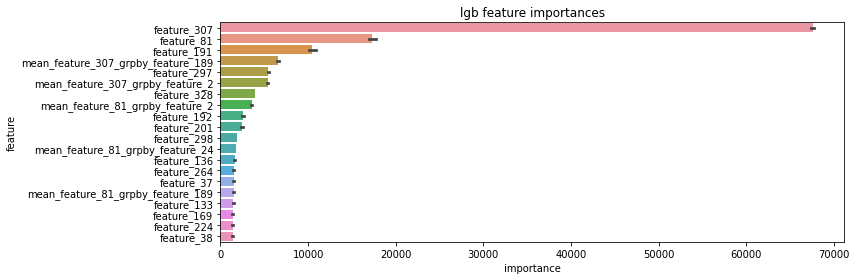

In [17]:
order = list(lgb_importances.groupby("feature").mean().sort_values("importance", ascending=False).index)
plt.figure(figsize=(12, 4), tight_layout=True)
sns.barplot(x="importance", y="feature", data=lgb_importances, order=order[:20])
plt.title("{} feature importances".format("lgb"))
plt.tight_layout()

# XGBoost

In [18]:
xgb_params = {
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.6,
    'colsample_bylevel': 0.6,
    'booster': 'gbtree',
    'objective': 'reg:squarederror',
    'n_estimators': N_ESTIMATORS,
    'seed': SEED,
    'learning_rate': 8e-3,
    'use_label_encoder': False,
    'importance_type': 'gain',
    'tree_method': 'gpu_hist',
    'predictor': 'gpu_predictor'
}

In [19]:
features = cat_features + num_features
shap_values = np.zeros((train.shape[0], train[features].shape[1]))
xgb_oof = np.zeros(train.shape[0])
xgb_pred = np.zeros(test.shape[0])

start = time.time()

rskf = RepeatedStratifiedKFold(n_splits=N_SPLITS, n_repeats=N_REPEATS, random_state=SEED)
for fold, (trn_idx, val_idx) in enumerate(tqdm(rskf.split(X=train, y=train[target_column]), total=N_SPLITS*N_REPEATS)):
    X_train, y_train = train[features].iloc[trn_idx], train[target_column].iloc[trn_idx]
    X_valid, y_valid = train[features].iloc[val_idx], train[target_column].iloc[val_idx]
    X_test = test[features]

    model = xgb.XGBRegressor(**xgb_params)
    model.fit(X_train,
              y_train,
              eval_set=[(X_valid, y_valid)],
              eval_metric='auc',
              early_stopping_rounds=EARLY_STOPPING_ROUNDS,
              verbose=VERBOSE
             )

    shap_values[val_idx] += shap.TreeExplainer(model).shap_values(X_valid)
    xgb_oof[val_idx] = model.predict(X_valid)
    xgb_pred += model.predict(X_test) / N_SPLITS / N_REPEATS

    auc = roc_auc_score(y_valid, xgb_oof[val_idx])

elapsed = time.time() - start
auc = roc_auc_score(train[target_column], xgb_oof)
print(f"AUC: {auc:6f}, elapsed time: {elapsed:.2f}sec")

train[f'xgb'] = xgb_oof
test[f'xgb'] = xgb_pred

  0%|          | 0/50 [00:00<?, ?it/s]

AUC: 0.786629, elapsed time: 2640.57sec


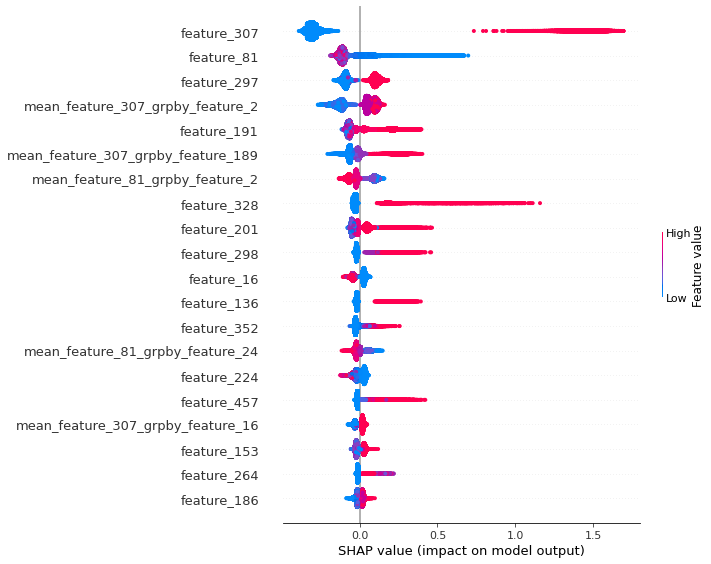

In [20]:
shap.summary_plot(shap_values, features=train[features])

# CatBoost

In [21]:
ctb_params = {
    'bootstrap_type': 'Bayesian',
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE',
    'random_seed': SEED,
    'task_type': 'GPU',
    'max_depth': 6,
    'learning_rate': 8e-3,
    'n_estimators': N_ESTIMATORS,
}

In [22]:
features = cat_features + num_features
ctb_importances = pd.DataFrame()
ctb_oof = np.zeros(train.shape[0])
ctb_pred = np.zeros(test.shape[0])

start = time.time()

rskf = RepeatedStratifiedKFold(n_splits=N_SPLITS, n_repeats=N_REPEATS, random_state=SEED)
for fold, (trn_idx, val_idx) in enumerate(tqdm(rskf.split(X=train, y=train[target_column]), total=N_SPLITS*N_REPEATS)):
    X_train, y_train = train[features].iloc[trn_idx], train[target_column].iloc[trn_idx]
    X_valid, y_valid = train[features].iloc[val_idx], train[target_column].iloc[val_idx]
    X_test = test[features]

    model = ctb.CatBoostRegressor(**ctb_params)
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_valid, y_valid)],
        use_best_model=True,
        early_stopping_rounds=EARLY_STOPPING_ROUNDS,
        verbose=VERBOSE
    )

    fi_tmp = pd.DataFrame()
    fi_tmp['feature'] = X_train.columns
    fi_tmp['importance'] = model.feature_importances_
    fi_tmp['fold'] = fold
    fi_tmp['seed'] = SEED
    ctb_importances = ctb_importances.append(fi_tmp)

    ctb_oof[val_idx] = model.predict(X_valid)
    ctb_pred += model.predict(X_test) / N_SPLITS / N_REPEATS

    auc = roc_auc_score(y_valid, ctb_oof[val_idx])

elapsed = time.time() - start
auc = roc_auc_score(train[target_column], ctb_oof)
print(f"AUC: {auc:6f}, elapsed time: {elapsed:.2f}sec")

train[f'ctb'] = ctb_oof
test[f'ctb'] = ctb_pred

  0%|          | 0/50 [00:00<?, ?it/s]

AUC: 0.786814, elapsed time: 3138.34sec


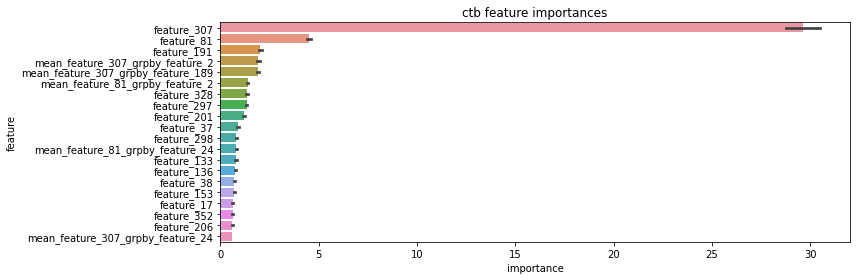

In [23]:
order = list(ctb_importances.groupby("feature").mean().sort_values("importance", ascending=False).index)
plt.figure(figsize=(12, 4), tight_layout=True)
sns.barplot(x="importance", y="feature", data=ctb_importances, order=order[:20])
plt.title("{} feature importances".format("ctb"))
plt.tight_layout()

# Stacking

In [24]:
stack_features = []

stack_features += [col for col in train.columns if 'lgb' in col]
stack_features += [col for col in train.columns if 'xgb' in col]
stack_features += [col for col in train.columns if 'ctb' in col]

In [25]:
stack_oof = np.zeros(train.shape[0])
stack_pred = np.zeros(test.shape[0])
        
rskf = RepeatedStratifiedKFold(n_splits=N_SPLITS, n_repeats=N_REPEATS, random_state=SEED)
for fold, (trn_idx, val_idx) in enumerate(tqdm(rskf.split(X=train, y=train[target_column]), total=N_SPLITS*N_REPEATS)):
    X_train, y_train = train[stack_features].iloc[trn_idx], train[target_column].iloc[trn_idx]
    X_valid, y_valid = train[stack_features].iloc[val_idx], train[target_column].iloc[val_idx]
    X_test = test[stack_features]

    start = time.time()
    model = RidgeCV()
    model.fit(X_train, y_train)

    stack_oof[val_idx] = model.predict(X_valid)
    stack_pred += model.predict(X_test) / N_SPLITS / N_REPEATS

    elapsed = time.time() - start
    auc = roc_auc_score(y_valid, stack_oof[val_idx])
    print(f"fold {fold} - stack auc: {auc:.6f}, elapsed time: {elapsed:.2f}sec")

auc = roc_auc_score(train[target_column], stack_oof)
print(f"oof stack auc = {auc:.6f}")

  0%|          | 0/50 [00:00<?, ?it/s]

fold 0 - stack auc: 0.794986, elapsed time: 0.04sec
fold 1 - stack auc: 0.792444, elapsed time: 0.02sec
fold 2 - stack auc: 0.785006, elapsed time: 0.02sec
fold 3 - stack auc: 0.787393, elapsed time: 0.02sec
fold 4 - stack auc: 0.786042, elapsed time: 0.03sec
fold 5 - stack auc: 0.787976, elapsed time: 0.03sec
fold 6 - stack auc: 0.779696, elapsed time: 0.03sec
fold 7 - stack auc: 0.792112, elapsed time: 0.02sec
fold 8 - stack auc: 0.789020, elapsed time: 0.02sec
fold 9 - stack auc: 0.777861, elapsed time: 0.04sec
fold 10 - stack auc: 0.794370, elapsed time: 0.04sec
fold 11 - stack auc: 0.796309, elapsed time: 0.04sec
fold 12 - stack auc: 0.781105, elapsed time: 0.04sec
fold 13 - stack auc: 0.778468, elapsed time: 0.04sec
fold 14 - stack auc: 0.792588, elapsed time: 0.06sec
fold 15 - stack auc: 0.782916, elapsed time: 0.08sec
fold 16 - stack auc: 0.796521, elapsed time: 0.05sec
fold 17 - stack auc: 0.787746, elapsed time: 0.03sec
fold 18 - stack auc: 0.789990, elapsed time: 0.04sec
fol

In [26]:
submission[target_column] = stack_pred
submission.to_csv("submission.csv", index=False)
submission

,id,target
0,5,0.421597
1,7,0.344590
2,9,0.345759
3,11,0.118148
4,14,0.287831
...,...,...
29995,99981,0.660740
29996,99982,0.306794
29997,99992,0.153379
29998,99993,0.574472
